In [1]:
# %%
try:
    from IPython import get_ipython
    if get_ipython() is not None:
        %load_ext autoreload
        %autoreload 2
except ImportError:
    pass

# %%
import pandas as pd
from os.path import join
import glob
import os
from os.path import join
import torch
import torch as th
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm.auto import trange
from contextlib import redirect_stdout

import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation/PixArt-alpha")
from diffusion import IDDPM
from diffusion.data.builder import build_dataset, build_dataloader, set_data_root
from diffusion.model.builder import build_model
from diffusion.utils.misc import set_random_seed, read_config, init_random_seed, DebugUnderflowOverflow
from diffusers import AutoencoderKL, Transformer2DModel, PixArtAlphaPipeline, DPMSolverMultistepScheduler
from transformers import T5Tokenizer, T5EncoderModel

sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation")
from utils.pixart_sampling_utils import pipeline_inference_custom, \
    PixArtAlphaPipeline_custom
from utils.pixart_utils import state_dict_convert
from utils.text_encoder_control_lib import RandomEmbeddingEncoder_wPosEmb
from utils.image_utils import pil_images_to_grid
from utils.attention_map_store_utils import replace_attn_processor, AttnProcessor2_0_Store, PixArtAttentionVisualizer_Store
from utils.cv2_eval_utils import find_classify_object_masks, evaluate_parametric_relation
from utils.cv2_eval_utils import find_classify_objects, evaluate_parametric_relation, eval_func_factory, scene_info_collection
from utils.attention_analysis_lib import plot_attention_layer_head_heatmaps, plot_layer_head_score_summary
from utils.attention_analysis_lib import *
from utils.obj_mask_utils import *
from circuit_toolkit.plot_utils import saveallforms
import pandas as pd
from tqdm.auto import tqdm

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Pleas

In [2]:
model_run_name = "objrel_rndembdposemb_DiT_mini_pilot" # "objrel_rndembdposemb_DiT_B_pilot" 
# ckpt_name = "epoch_4000_step_160000.pth" # "epoch_4000_step_160000.pth" 
text_encoder_type = "RandomEmbeddingEncoder_wPosEmb" 
suffix = ""

In [3]:
savedir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/{model_run_name}"
# figdir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/{model_run_name}{suffix}/cross_attn_vis_figs"
result_dir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/{model_run_name}{suffix}"
eval_dir = join(savedir, "large_scale_eval_posthoc")

In [4]:
eval_df_all_traj = pd.read_csv(join(eval_dir, f"eval_df_all_train_traj_prompts.csv"))
object_df_all_traj = pd.read_pickle(join(eval_dir, f"object_df_all_train_traj_prompts.pkl"))

In [5]:
eval_df_all_traj

,step_num,ckpt_ver,sample_id,prompt,prompt_id,overall,shape,color,spatial_relationship,Dx,Dy,x1,y1,x2,y2
0,2000,ema,0,red square is above the blue triangle,0,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,ema,1,red square is above the blue triangle,0,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
2,2000,ema,2,red square is above the blue triangle,0,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
3,2000,ema,3,red square is above the blue triangle,0,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
4,2000,ema,4,red square is above the blue triangle,0,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1535995,160000,model,95,blue circle is below and to the right of the r...,95,True,True,True,True,78.0,64.0,94.0,101.0,16.0,37.0
1535996,160000,model,96,blue circle is below and to the right of the r...,95,True,True,True,True,35.0,62.0,110.0,87.0,75.0,25.0
1535997,160000,model,97,blue circle is below and to the right of the r...,95,True,True,True,True,80.0,65.0,99.0,96.0,19.0,31.0
1535998,160000,model,98,blue circle is below and to the right of the r...,95,True,True,True,True,65.0,48.0,96.0,85.0,31.0,37.0


In [ ]:
# %%
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
eval_df_all_traj.groupby(["step_num", "ckpt_ver"]).mean(numeric_only=True)

In [11]:
eval_df_all_traj_syn = eval_df_all_traj.groupby(["step_num", "ckpt_ver"]).mean(numeric_only=True)

In [12]:
eval_df_all_traj_syn

sample_id  prompt_id   overall     shape     color  \
step_num ckpt_ver                                                       
2000     ema            49.5       47.5  0.000000  0.400104  0.000000   
         model          49.5       47.5  0.000000  0.042500  0.021458   
4000     ema            49.5       47.5  0.000000  0.440208  0.000000   
         model          49.5       47.5  0.001354  0.105729  0.101771   
6000     ema            49.5       47.5  0.000000  0.490729  0.000000   
...                      ...        ...       ...       ...       ...   
156000   model          49.5       47.5  0.526979  0.835313  0.892292   
158000   ema            49.5       47.5  0.555625  0.874792  0.934479   
         model          49.5       47.5  0.527396  0.836042  0.930937   
160000   ema            49.5       47.5  0.558333  0.875938  0.934479   
         model          49.5       47.5  0.515417  0.828646  0.882188   

                   spatial_relationship        Dx         Dy         x1  \
step_num ckpt_ver                                                         
2000     ema                   0.000000       NaN        NaN        NaN   
         model                 0.000000 -2.250000  29.000000  43.750000   
4000     ema                   0.000000       NaN        NaN        NaN   
         model                 0.001354  1.173469  -1.836735  53.540816   
6000     ema                   0.000000       NaN        NaN        NaN   
...                                 ...       ...        ...        ...   
156000   model                 0.526979  4.031905  -0.889178  65.973174   
158000   ema                   0.555625  0.601867   0.478693  64.872529   
         model                 0.527396 -0.387737  -0.679414  63.482240   
160000   ema                   0.558333  0.744968   0.391875  64.932622   
         model                 0.515417  1.004792   1.802183  63.975506   

                          y1         x2         y2  
step_num ckpt_ver                                   
2000     ema             NaN        NaN        NaN  
         model     78.000000  46.000000  49.000000  
4000     ema             NaN        NaN        NaN  
         model     59.530612  52.367347  61.367347  
6000     ema             NaN        NaN        NaN  
...                      ...        ...        ...  
156000   model     64.731736  61.941268  65.620914  
158000   ema       65.368906  64.270662  64.890212  
         model     61.786881  63.869977  62.466295  
160000   ema       65.313451  64.187653  64.921576  
         model     67.657614  62.970714  65.855431  

[160 rows x 12 columns]

In [20]:
eval_df_all_traj_syn.reset_index()

,step_num,ckpt_ver,sample_id,prompt_id,overall,shape,color,spatial_relationship,Dx,Dy,x1,y1,x2,y2
0,2000,ema,49.5,47.5,0.000000,0.400104,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,model,49.5,47.5,0.000000,0.042500,0.021458,0.000000,-2.250000,29.000000,43.750000,78.000000,46.000000,49.000000
2,4000,ema,49.5,47.5,0.000000,0.440208,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,4000,model,49.5,47.5,0.001354,0.105729,0.101771,0.001354,1.173469,-1.836735,53.540816,59.530612,52.367347,61.367347
4,6000,ema,49.5,47.5,0.000000,0.490729,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,156000,model,49.5,47.5,0.526979,0.835313,0.892292,0.526979,4.031905,-0.889178,65.973174,64.731736,61.941268,65.620914
156,158000,ema,49.5,47.5,0.555625,0.874792,0.934479,0.555625,0.601867,0.478693,64.872529,65.368906,64.270662,64.890212
157,158000,model,49.5,47.5,0.527396,0.836042,0.930937,0.527396,-0.387737,-0.679414,63.482240,61.786881,63.869977,62.466295
158,160000,ema,49.5,47.5,0.558333,0.875938,0.934479,0.558333,0.744968,0.391875,64.932622,65.313451,64.187653,64.921576


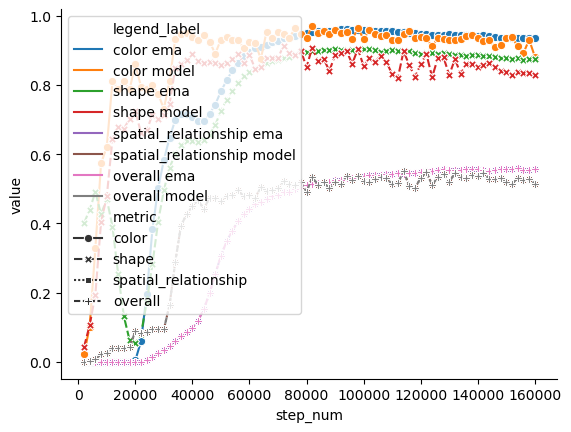

In [ ]:
# eval_df_all_traj_syn.droplevel
# 1) melt into long form
df_long = eval_df_all_traj_syn.reset_index().melt(
    id_vars=["step_num", "ckpt_ver"],
    value_vars=["color", "shape", "spatial_relationship", "overall"],
    var_name="metric",
    value_name="value",
)

# 2) make the combined label column
df_long["legend_label"] = df_long["metric"] + " " + df_long["ckpt_ver"]

# 3) plot, using legend_label for hue and metric for style (if you still want different markers/linestyles)
sns.lineplot(
    data=df_long,
    x="step_num",
    y="value",
    hue="metric",
    style="ckpt_ver",
    markers=True,    # or dashes=True
)
plt.legend(loc="upper left", title="")
plt.show()

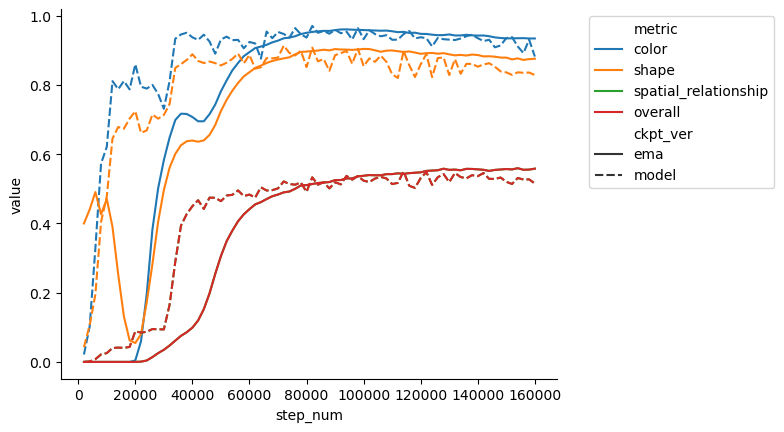

In [ ]:

# 3) plot, using legend_label for hue and metric for style (if you still want different markers/linestyles)
sns.lineplot(
    data=df_long,
    x="step_num",
    y="value",
    hue="metric",
    style="ckpt_ver",
    markers=False,    # or dashes=True
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="")
plt.suptitle(f"Synthetic Trajectory\n{model_run_name}")
plt.show()

TypeError: functools.partial(<class 'matplotlib.lines.Line2D'>, xdata=[], ydata=[]) got multiple values for keyword argument 'label'

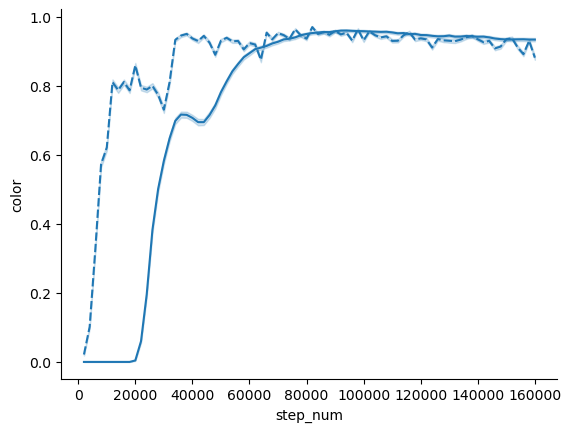

In [17]:
sns.lineplot(data=eval_df_all_traj, x="step_num", y="color", style="ckpt_ver", label="color")
sns.lineplot(data=eval_df_all_traj, x="step_num", y="shape", style="ckpt_ver", label="shape")
sns.lineplot(data=eval_df_all_traj, x="step_num", y="spatial_relationship", style="ckpt_ver", label="spatial_relationship")
sns.lineplot(data=eval_df_all_traj, x="step_num", y="overall", style="ckpt_ver", label="overall")
plt.legend(loc="upper left")
plt.show()

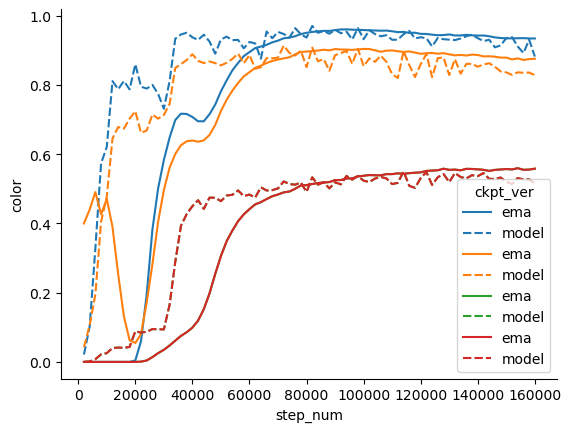

In [ ]:

sns.lineplot(data=eval_df_all_traj_syn, x="step_num", y="color", style="ckpt_ver")
sns.lineplot(data=eval_df_all_traj_syn, x="step_num", y="shape", style="ckpt_ver")
sns.lineplot(data=eval_df_all_traj_syn, x="step_num", y="spatial_relationship", style="ckpt_ver")
sns.lineplot(data=eval_df_all_traj_syn, x="step_num", y="overall", style="ckpt_ver")
plt.show()

In [25]:
model_run_name = "objrel_T5_DiT_B_pilot" # "objrel_rndembdposemb_DiT_B_pilot" 
# ckpt_name = "epoch_4000_step_160000.pth" # "epoch_4000_step_160000.pth" 
text_encoder_type = "T5" 
suffix = ""

In [26]:
savedir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/{model_run_name}"
# figdir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/{model_run_name}{suffix}/cross_attn_vis_figs"
result_dir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/{model_run_name}{suffix}"
eval_dir = join(savedir, "large_scale_eval_posthoc")
eval_df_all_traj = pd.read_csv(join(eval_dir, f"eval_df_all_train_traj_prompts.csv"))
object_df_all_traj = pd.read_pickle(join(eval_dir, f"object_df_all_train_traj_prompts.pkl"))

In [28]:
eval_df_all_traj_syn = eval_df_all_traj.groupby(["step_num", "ckpt_ver"]).mean(numeric_only=True).reset_index()

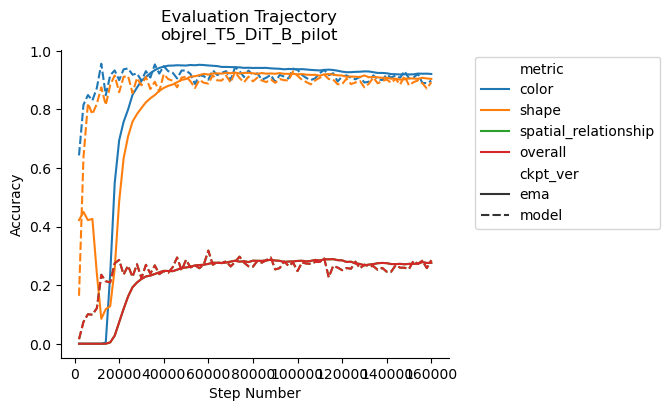

In [30]:
# eval_df_all_traj_syn.droplevel
# 1) melt into long form
df_long = eval_df_all_traj_syn.reset_index().melt(
    id_vars=["step_num", "ckpt_ver"],
    value_vars=["color", "shape", "spatial_relationship", "overall"],
    var_name="metric",
    value_name="value",
)
# 2) make the combined label column
df_long["legend_label"] = df_long["metric"] + " " + df_long["ckpt_ver"]
# 3) plot, using legend_label for hue and metric for style (if you still want different markers/linestyles)
plt.figure(figsize=(5, 4))
sns.lineplot(
    data=df_long,
    x="step_num",
    y="value",
    hue="metric",
    style="ckpt_ver",
    markers=False,    # or dashes=True
)
plt.xlabel("Step Number")
plt.ylabel("Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="")
plt.suptitle(f"Evaluation Trajectory\n{model_run_name}")
plt.show()

### Mass produce 

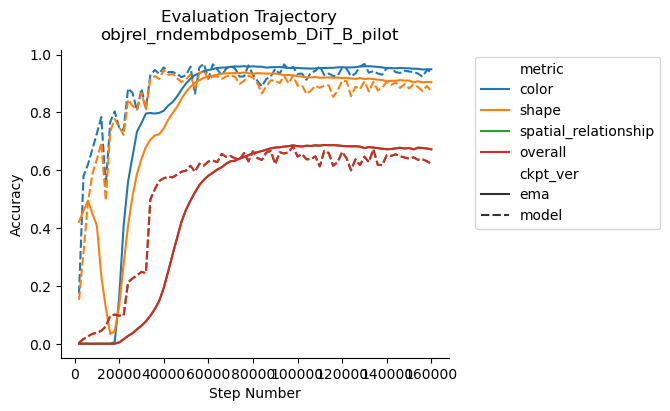

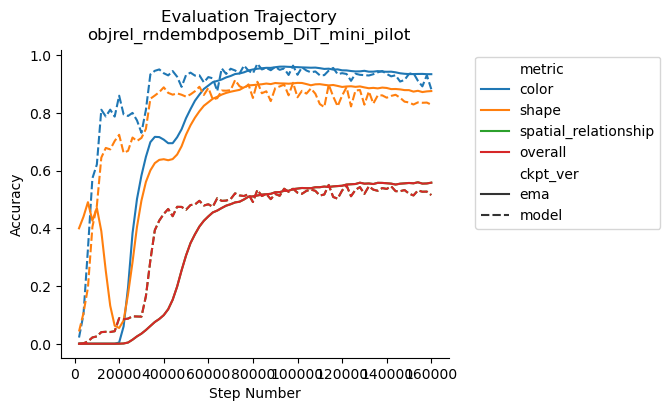

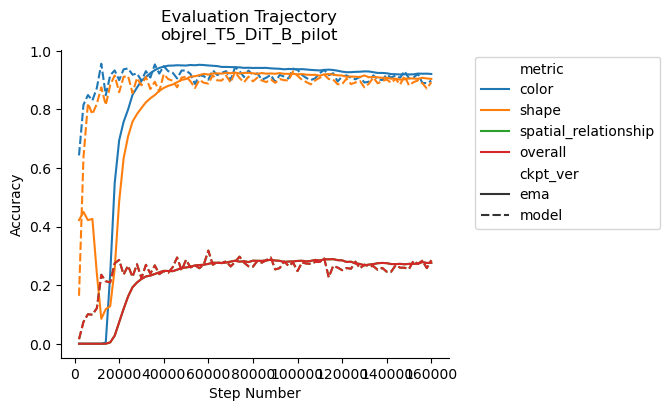

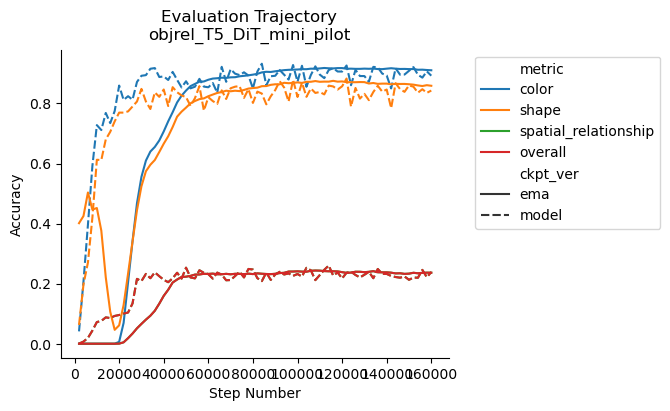

In [31]:
for model_run_name in ["objrel_rndembdposemb_DiT_B_pilot", 
                        "objrel_rndembdposemb_DiT_mini_pilot", 
                        "objrel_T5_DiT_B_pilot", 
                        "objrel_T5_DiT_mini_pilot", 
                        ]:
    savedir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/{model_run_name}"
    # figdir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/{model_run_name}{suffix}/cross_attn_vis_figs"
    # result_dir = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/{model_run_name}{suffix}"
    eval_dir = join(savedir, "large_scale_eval_posthoc")
    eval_df_all_traj = pd.read_csv(join(eval_dir, f"eval_df_all_train_traj_prompts.csv"))
    object_df_all_traj = pd.read_pickle(join(eval_dir, f"object_df_all_train_traj_prompts.pkl"))
    eval_df_all_traj_syn = eval_df_all_traj.groupby(["step_num", "ckpt_ver"]).mean(numeric_only=True).reset_index()
    # eval_df_all_traj_syn.droplevel
    # 1) melt into long form
    df_long = eval_df_all_traj_syn.reset_index().melt(
        id_vars=["step_num", "ckpt_ver"],
        value_vars=["color", "shape", "spatial_relationship", "overall"],
        var_name="metric",
        value_name="value",
    )
    # 2) make the combined label column
    df_long["legend_label"] = df_long["metric"] + " " + df_long["ckpt_ver"]
    # 3) plot, using legend_label for hue and metric for style (if you still want different markers/linestyles)
    plt.figure(figsize=(5, 4))
    sns.lineplot(
        data=df_long,
        x="step_num",
        y="value",
        hue="metric",
        style="ckpt_ver",
        markers=False,    # or dashes=True
    )
    plt.xlabel("Step Number")
    plt.ylabel("Accuracy")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="")
    plt.suptitle(f"Evaluation Trajectory\n{model_run_name}")
    saveallforms(eval_dir, "eval_train_dynamics_traj_syn")
    plt.show()